### Step 1: Install and Import Required Libraries

In [28]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import importlib
import random

# import models
import hopfield_baseline
import hopfield_PSL
import storkey
import spiking
import grayscaled_hp_baseline


## Method 1 CIFAR-10 Data Preprocessing

### Step 2: Load the CIFAR-10 Dataset

In [3]:
# defining a transform for converting images to grayscale and tensors
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# Load training and test datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
color_trainset = datasets.CIFAR10(root='./data', train=True, download=True)

print(f'Training set size: {len(train_dataset)}')

Training set size: 50000


### Step 3: Binarize the Images to -1/+1

In [4]:
# convert images to numpy arrays
train_images = torch.stack([img for img,_ in train_dataset]).numpy()

# binarize the images
train_images = np.where(train_images > 0.5, 1, -1)

# verify the range of values
print(f'Unique pixel values after binarization: {np.unique(train_images)}')

Unique pixel values after binarization: [-1  1]


### Step 4: Reshape Images into 1024-bit Vectors

In [5]:
train_images = train_images.reshape(len(train_images), -1)

### Step 6: Visualize Some Binarized Images

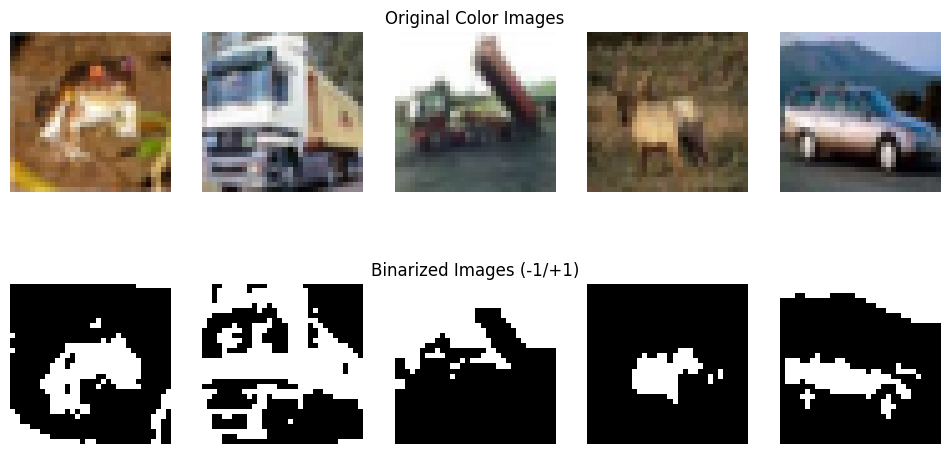

In [6]:
num_images = 5
fig, axes = plt.subplots(2,num_images,figsize=(12,6))
for i in range(num_images):
    # Plot the original color images
    axes[0,i].imshow(color_trainset.data[i])
    axes[0,i].axis('off')

    # Plot binarized grayscale images
    axes[1,i].imshow(train_images[i].reshape(32,32), cmap='gray')
    axes[1,i].axis('off')

axes[0,num_images//2].set_title('Original Color Images', fontsize=12, loc='center')
axes[1,num_images//2].set_title('Binarized Images (-1/+1)', fontsize=12, loc='center')

plt.show()

### Step 7: Generate a Corrupted Subset of Training Images

In [7]:
def corrupt_images(images, corruption_type="mask ", corruption_fraction=0.25):
    """
    Corrupt images by either masking pixels or flipping them

    Args:
        images (numpy array): binarized images to corrupt
        corruption_type (str): "mask" to set pixels to 0, "flip" to invert pixels
        corruption_fraction (float): Fraction of pixels to corrupt

    Returns:
        numpy array: Corrupted images
    """
    corrupted_images = images.copy()
    num_pixels = images.shape[1]
    num_corrupt = int(corruption_fraction * num_pixels)

    for img in corrupted_images:
        corrupt_indices = np.random.choice(num_pixels, num_corrupt, replace=False)

        if corruption_type == 'mask':
            img[corrupt_indices] = 0
        elif corruption_type == 'flip':
            img[corrupt_indices] *= -1
    return corrupted_images

In [8]:
# create corrupted images to use as test set
masked_images = corrupt_images(train_images, corruption_type='mask', corruption_fraction=0.25)
flipped_images = corrupt_images(train_images, corruption_type='flip', corruption_fraction=0.25)

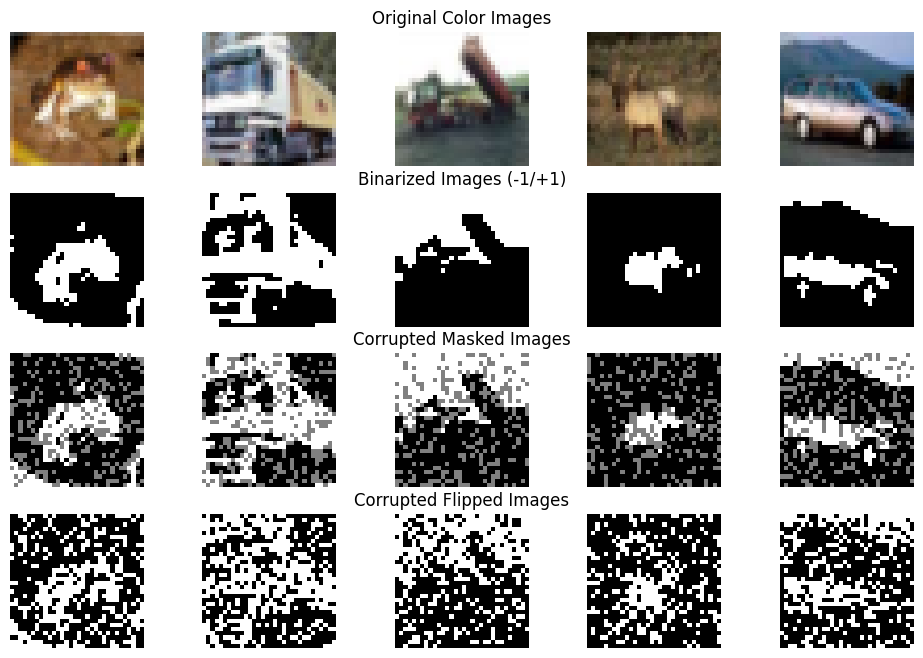

In [9]:
# Visualize some corrupted images

num_images = 5
fig, axes = plt.subplots(4,num_images,figsize=(12,8))
for i in range(num_images):
    # Plot the original color images
    axes[0,i].imshow(color_trainset.data[i])
    axes[0,i].axis('off')

    # Plot binarized grayscale images
    axes[1,i].imshow(train_images[i].reshape(32,32), cmap='gray')
    axes[1,i].axis('off')

    # Plot corrupted masked images
    axes[2,i].imshow(masked_images[i].reshape(32,32), cmap='gray')
    axes[2,i].axis('off')

    # Plot corrupted flipped images
    axes[3,i].imshow(flipped_images[i].reshape(32,32), cmap='gray')
    axes[3,i].axis('off')

axes[0,num_images//2].set_title('Original Color Images', fontsize=12, loc='center')
axes[1,num_images//2].set_title('Binarized Images (-1/+1)', fontsize=12, loc='center')
axes[2,num_images//2].set_title('Corrupted Masked Images', fontsize=12, loc='center')
axes[3,num_images//2].set_title('Corrupted Flipped Images', fontsize=12, loc='center')


plt.show()

### Step 8: Save the Preprocessed Datasets

In [10]:
# Create 'data/binarized' directory if it doesn't exist
if not os.path.isdir('data/binarized'):
    os.mkdir('data/binarized')

np.save("data/binarized/train_images.npy", train_images)
np.save("data/binarized/masked_images.npy", masked_images)
np.save("data/binarized/flipped_images.npy", flipped_images)


## Method 2 CIFAR-10 Data Preprocessing

### Step 9: Save Grayscale Images

In [122]:
importlib.reload(grayscaled_hp_baseline)

# Create directory to save grayscale images
save_dir = 'data/grayscale_images'
os.makedirs(save_dir, exist_ok=True)

# convert grayscale encoded images to numpy arrays
encoded_images = torch.stack([grayscaled_hp_baseline.encode(img) for img,_ in train_dataset]).numpy()

masked_gray_images = corrupt_images(encoded_images, corruption_type='mask', corruption_fraction=0.25)
flipped_gray_images = corrupt_images(encoded_images, corruption_type='flip', corruption_fraction=0.25)

print(f'Training set size: {len(encoded_images)}')
np.save(os.path.join(save_dir, "train_images.npy"), encoded_images)
np.save(os.path.join(save_dir, "masked_images.npy"), masked_gray_images)
np.save(os.path.join(save_dir, "flipped_images.npy"), flipped_gray_images)

(50000, 8192)
Training set size: 50000


## Training Baseline

### Method 1

In [186]:
# load training data
stored_images = np.load("data/binarized/train_images.npy")
masked_images = np.load("data/binarized/masked_images.npy")
flipped_images = np.load("data/binarized/flipped_images.npy")

# convert to PyTorch tensors
stored_images = torch.tensor(stored_images, dtype=torch.float32)
masked_images = torch.tensor(masked_images, dtype=torch.float32)
flipped_images = torch.tensor(flipped_images, dtype=torch.float32)

In [187]:
importlib.reload(hopfield_baseline)

num_neurons = 1024
num_patterns = 5
hopfield_rnn = hopfield_baseline.HopfieldRNN(num_units=num_neurons)

# randomly select from training set
idxs = np.random.choice(range(len(stored_images)), size=num_patterns, replace=False)

baseline_original = stored_images[idxs]
baseline_masked = masked_images[idxs]
baseline_flipped = flipped_images[idxs]

# store patterns using Hebbian learning
hopfield_rnn.store_patterns(baseline_original)

In [188]:
# Retrieve images from corrupted inputs
retrieved_masked = hopfield_rnn(baseline_masked)
retrieved_flipped = hopfield_rnn(baseline_flipped)

In [189]:
# Compute MSE Loss
loss_masked = hopfield_rnn.recall_loss(baseline_masked, baseline_original)
loss_flipped = hopfield_rnn.recall_loss(baseline_flipped, baseline_original)

print(f"Reconstruction MSE Loss (Masked Images): {loss_masked.item():.4f}")
print(f"Reconstruction MSE Loss (Flipped Images): {loss_flipped.item():.4f}")

print('-'*50)

# Compute accuracy
masked_acc = hopfield_rnn.recall_accuracy(baseline_masked, baseline_original)
flipped_acc = hopfield_rnn.recall_accuracy(baseline_flipped, baseline_original)

print(f"Reconstruction Accuracy (Masked Images): {masked_acc:.4f}")
print(f"Reconstruction Accuracy (Flipped Images): {flipped_acc:.4f}")

Reconstruction MSE Loss (Masked Images): 0.4422
Reconstruction MSE Loss (Flipped Images): 0.4422
--------------------------------------------------
Reconstruction Accuracy (Masked Images): 0.2000
Reconstruction Accuracy (Flipped Images): 0.2000


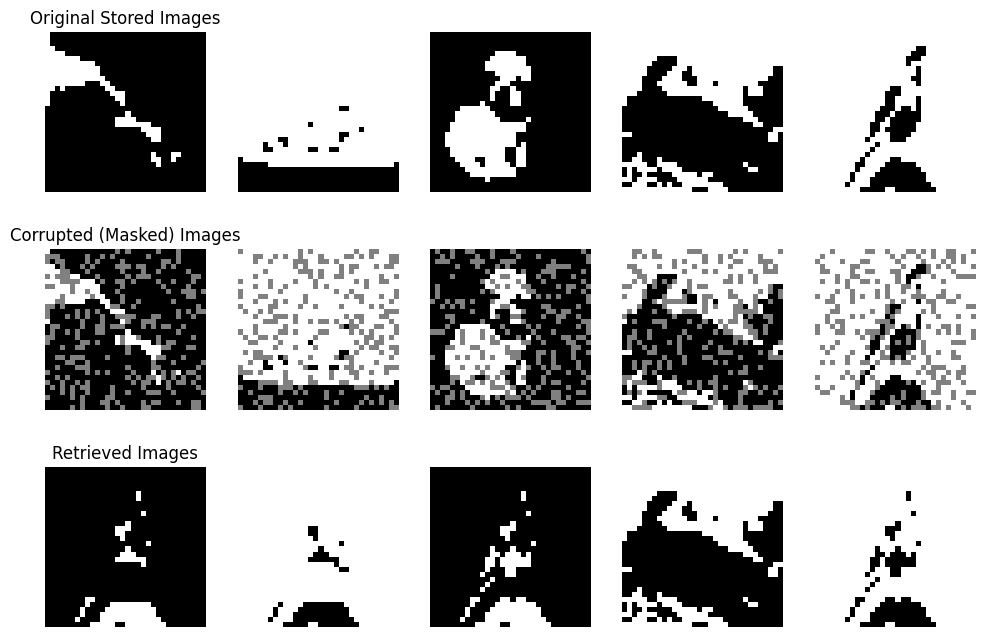

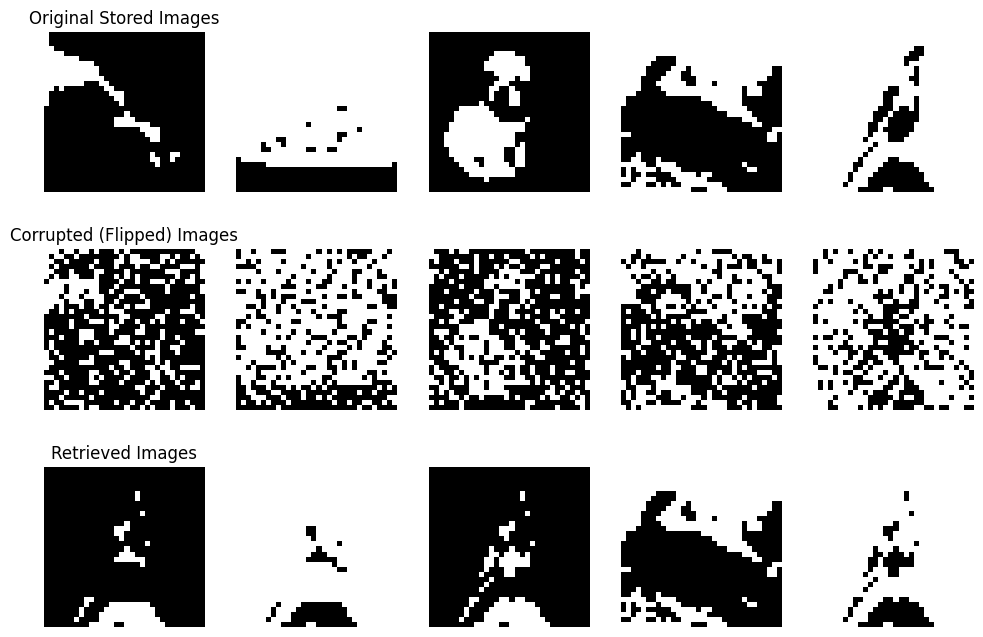

In [190]:

def plot_comparisons(original, corrupted, retrieved, title_corrupted, title_retrieved, num_samples=5):

    fig, axes = plt.subplots(3, num_samples, figsize=(12, 8))

    for i in range(num_samples):
        # Original stored image
        axes[0, i].imshow(original[i].reshape(32, 32), cmap='gray')
        axes[0, i].axis('off')

        # Corrupted image
        axes[1, i].imshow(corrupted[i].reshape(32, 32), cmap='gray')
        axes[1, i].axis('off')

        # Retrieved image
        axes[2, i].imshow(retrieved[i].reshape(32, 32), cmap='gray')
        axes[2, i].axis('off')

    # Add row titles
    axes[0, 0].set_title("Original Stored Images", fontsize=12, loc='center')
    axes[1, 0].set_title(title_corrupted, fontsize=12, loc='center')
    axes[2, 0].set_title(title_retrieved, fontsize=12, loc='center')

    plt.show()

# Plot results for masked images
plot_comparisons(baseline_original.numpy(), baseline_masked.numpy(), retrieved_masked.detach().numpy(),
                 "Corrupted (Masked) Images", "Retrieved Images")

# Plot results for flipped images
plot_comparisons(baseline_original.numpy(), baseline_flipped.numpy(), retrieved_flipped.detach().numpy(),
                 "Corrupted (Flipped) Images", "Retrieved Images")


#### Reconstructing Images for Increasing Stored Patterns

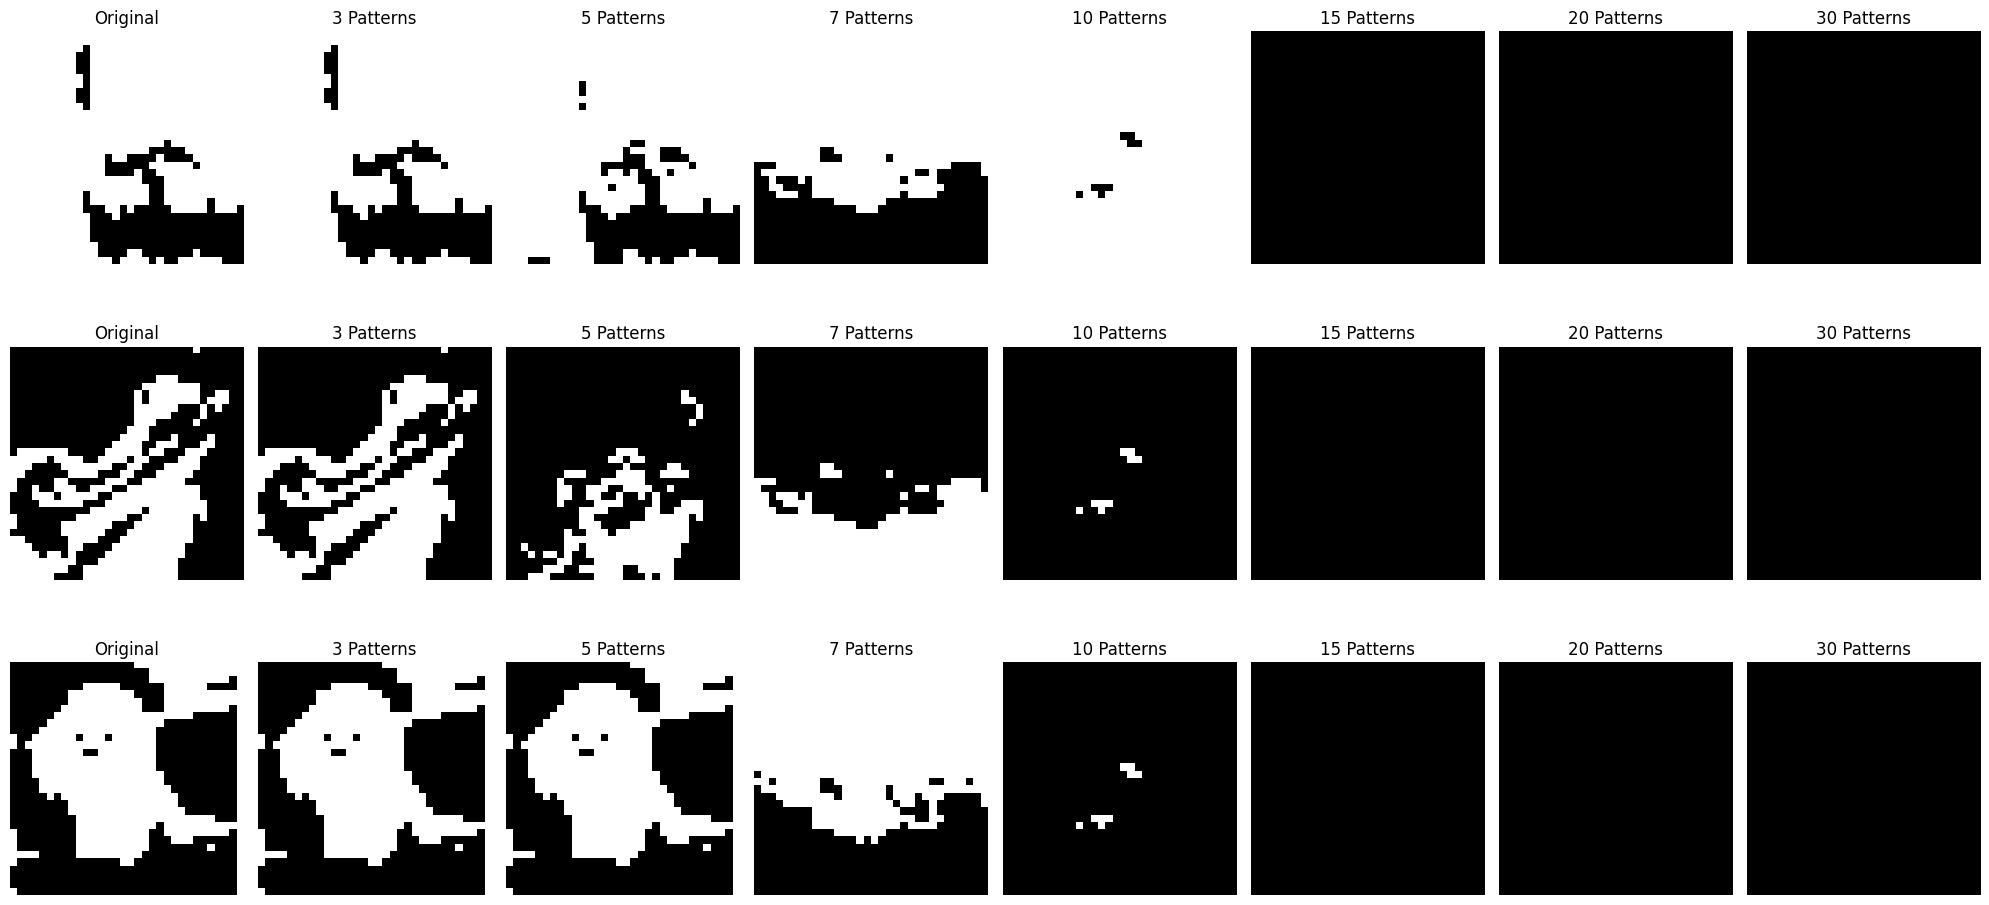

In [191]:
results = []
num_patterns_list = [3, 5, 7, 10, 15, 20, 30]
selected_idxs = set()
plot_idx = []

for i, num_patterns in enumerate(num_patterns_list):
    
    hopfield_rnn = hopfield_baseline.HopfieldRNN(num_units=1024)

    # Select new indices that have not been used previously
    remaining_idxs = list(set(range(len(stored_images))) - selected_idxs)  # The remaining available indices
    new_idxs = np.random.choice(remaining_idxs, size=num_patterns, replace=False)

    # Update the set of selected indices
    selected_idxs.update(new_idxs)

    if len(plot_idx) == 0:
        plot_idx = list(selected_idxs)

    baseline_original = stored_images[list(selected_idxs)]
    baseline_masked = masked_images[plot_idx]

    hopfield_rnn.store_patterns(baseline_original)

    retrieved_masked = hopfield_rnn(baseline_masked)

    # Store the results for plotting later
    results.append(retrieved_masked.detach().numpy())

# Create a large figure with an appropriate size
plt.figure(figsize=(20, 10))

# Loop through the rows (images)
for row, idx in enumerate(plot_idx, start=1):

    # Plot the original image
    plt.subplot(len(plot_idx), len(num_patterns_list)+1, (row-1)*(len(num_patterns_list)+1) + 1)
    plt.imshow(stored_images[plot_idx[row-1]].reshape(32,32), cmap='gray')
    plt.title(f'Original')
    plt.axis('off')

    # Plot the retrieved images for each number of patterns
    for i, num_patterns in enumerate(num_patterns_list):

        image_to_plot = results[i][row-1].reshape(32, 32)

        # Plot the image on the appropriate subplot axis
        plt.subplot(len(plot_idx), len(num_patterns_list)+1, (row-1)*(len(num_patterns_list)+1) + (i+2))
        plt.imshow(image_to_plot, cmap='gray')
        plt.title(f'{num_patterns} Patterns')
        plt.axis('off')

# Display the plots
plt.tight_layout()
plt.show()


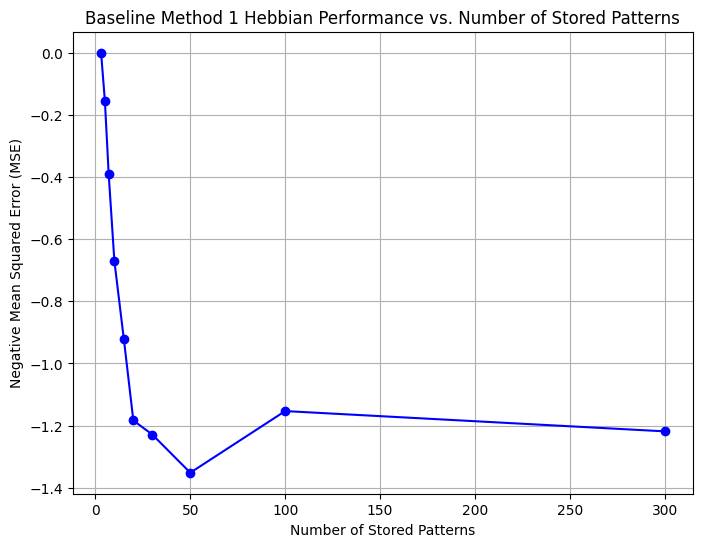

In [193]:

hebb_m1_results = []
hebb_m1_mse_values = []
num_patterns_list = [3, 5, 7, 10, 15, 20, 30, 50, 100, 300]

for i, num_patterns in enumerate(num_patterns_list):
    
    hopfield_rnn = hopfield_baseline.HopfieldRNN(num_units=1024)

    # randomly select from training set
    idxs = np.random.choice(range(len(stored_images)), size=num_patterns, replace=False)

    baseline_original = stored_images[idxs]
    baseline_masked = masked_images[idxs]

    hopfield_rnn.store_patterns(baseline_original)

    retrieved_masked = hopfield_rnn(baseline_masked)
    # loss = nn.MSELoss(retrieved_masked, baseline_original)
    loss = hopfield_rnn.recall_loss(baseline_masked, baseline_original)

    # Store the results for plotting later
    hebb_m1_results.append(retrieved_masked.detach().numpy())
    hebb_m1_mse_values.append(loss.detach().numpy())


# Plot the negative MSE curve (to make it appear decreasing)
plt.figure(figsize=(8, 6))
plt.plot(num_patterns_list, [-mse for mse in hebb_m1_mse_values], marker='o', linestyle='-', color='b')  # Negative SSE values
plt.title("Baseline Method 1 Hebbian Performance vs. Number of Stored Patterns")
plt.xlabel("Number of Stored Patterns")
plt.ylabel("Negative Mean Squared Error (MSE)")
plt.grid(True)
plt.show()



### Method 2 

Reconstruction MSE Loss (Masked Images): 0.0176
Reconstruction MSE Loss (Flipped Images): 0.0181


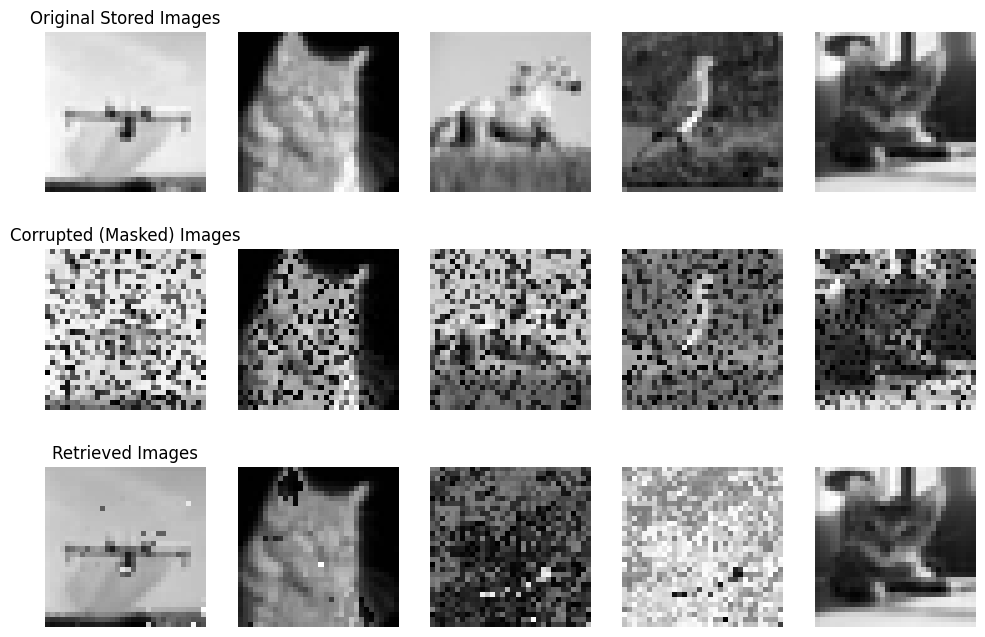

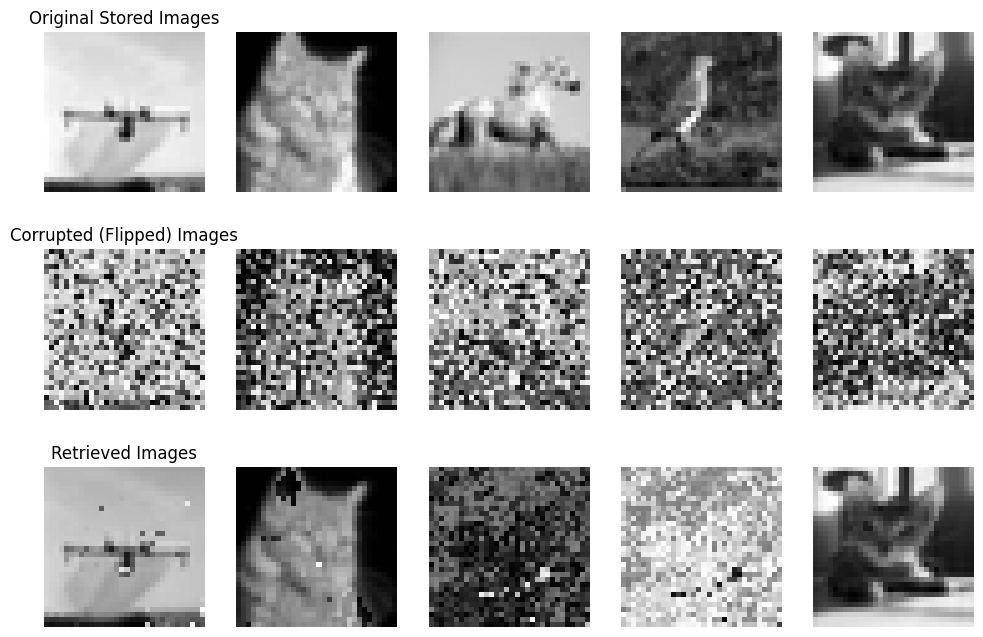

In [195]:
# Method 2 Preprocessing


# load training data
stored_images = np.load("data/grayscale_images/train_images.npy")
masked_images = np.load("data/grayscale_images/masked_images.npy")
flipped_images = np.load("data/grayscale_images/flipped_images.npy")

# convert to PyTorch tensors
stored_images = torch.tensor(stored_images, dtype=torch.float32)
masked_images = torch.tensor(masked_images, dtype=torch.float32)
flipped_images = torch.tensor(flipped_images, dtype=torch.float32)

importlib.reload(hopfield_baseline)
importlib.reload(grayscaled_hp_baseline)

num_neurons = 8192
num_patterns = 45
hopfield_gray = grayscaled_hp_baseline.HopfieldRNNGrayscale(num_units=num_neurons)

# randomly select from training set
idxs = np.random.choice(range(len(stored_images)), size=num_patterns, replace=False)

baseline_original = stored_images[idxs]
baseline_masked = masked_images[idxs]
baseline_flipped = flipped_images[idxs]

# store patterns using Hebbian learning
hopfield_gray.store_patterns(baseline_original)


# Retrieve images from corrupted inputs
retrieved_masked = hopfield_gray(baseline_masked).detach()
retrieved_flipped = hopfield_gray(baseline_flipped).detach()

# Convert back to grayscale
retrieved_masked = torch.stack([grayscaled_hp_baseline.decode(img) for img in retrieved_masked])
retrieved_flipped = torch.stack([grayscaled_hp_baseline.decode(img) for img in retrieved_flipped])

# Compute MSE Loss
loss_masked = hopfield_gray.recall_loss(baseline_masked, baseline_original)
loss_flipped = hopfield_gray.recall_loss(baseline_flipped, baseline_original)

print(f"Reconstruction MSE Loss (Masked Images): {loss_masked.item():.4f}")
print(f"Reconstruction MSE Loss (Flipped Images): {loss_flipped.item():.4f}")

baseline_original = torch.stack([grayscaled_hp_baseline.decode(img) for img in baseline_original])
baseline_masked = torch.stack([grayscaled_hp_baseline.decode(img) for img in baseline_masked])
baseline_flipped = torch.stack([grayscaled_hp_baseline.decode(img) for img in baseline_flipped])

# Plot results for masked images
plot_comparisons(baseline_original.numpy(), baseline_masked.numpy(), retrieved_masked,
                 "Corrupted (Masked) Images", "Retrieved Images")

# Plot results for flipped images
plot_comparisons(baseline_original.numpy(), baseline_flipped.numpy(), retrieved_flipped,
                 "Corrupted (Flipped) Images", "Retrieved Images")


#### Reconstructing Images for Increasing Stored Patterns

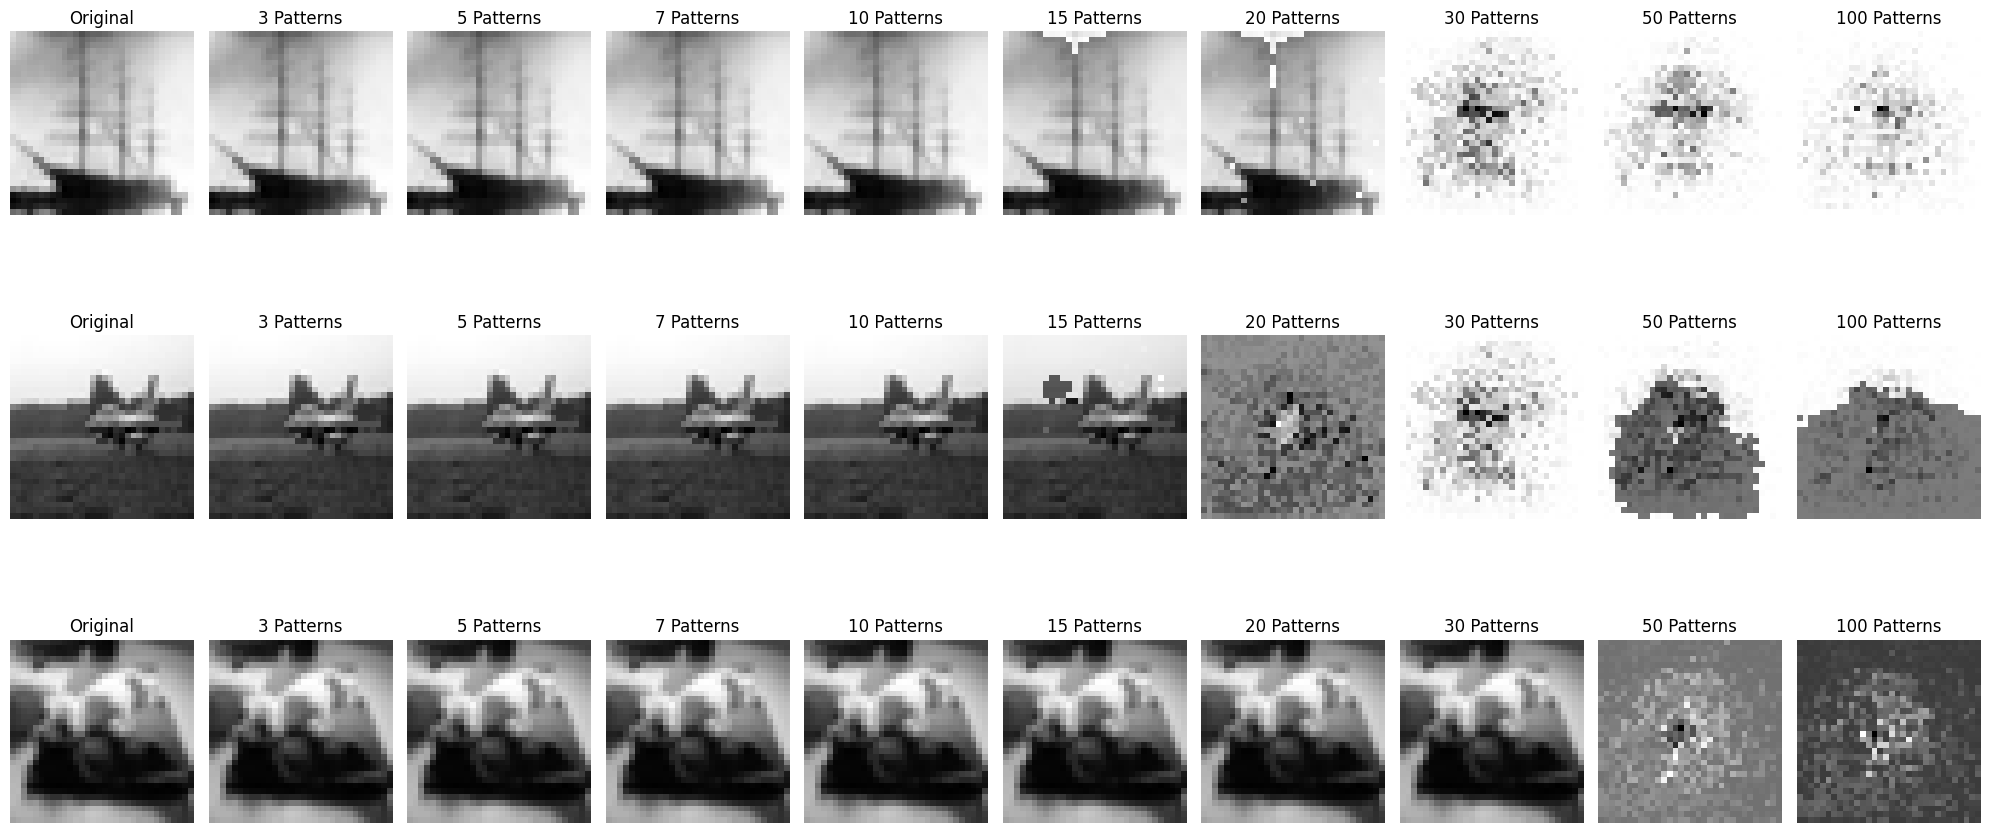

In [ ]:
results = []
num_patterns_list = [3, 5, 7, 10, 15, 20, 30, 50, 100]
selected_idxs = set()
plot_idx = []

for i, num_patterns in enumerate(num_patterns_list):
    
    hopfield_gray = grayscaled_hp_baseline.HopfieldRNNGrayscale(num_units=8192)

    # Select new indices that have not been used previously
    remaining_idxs = list(set(range(len(stored_images))) - selected_idxs)  # The remaining available indices
    new_idxs = np.random.choice(remaining_idxs, size=num_patterns, replace=False)

    # Update the set of selected indices
    selected_idxs.update(new_idxs)

    if len(plot_idx) == 0:
        plot_idx = list(selected_idxs)

    baseline_original = stored_images[list(selected_idxs)]
    baseline_masked = masked_images[plot_idx]

    hopfield_gray.store_patterns(baseline_original)

    # Retrieve images from corrupted inputs
    retrieved_masked = hopfield_gray(baseline_masked).detach()

    # Convert back to grayscale
    retrieved_masked = torch.stack([grayscaled_hp_baseline.decode(img) for img in retrieved_masked])

    # Store the results for plotting later
    results.append(retrieved_masked)

# Create a large figure with an appropriate size
plt.figure(figsize=(20, 10))

# Loop through the rows (images)
for row, idx in enumerate(plot_idx, start=1):

    # Plot the original image
    plt.subplot(len(plot_idx), len(num_patterns_list)+1, (row-1)*(len(num_patterns_list)+1) + 1)
    plt.imshow(grayscaled_hp_baseline.decode(stored_images[plot_idx[row-1]]), cmap='gray')
    # plt.imshow(stored_images[plot_idx[row-1]].reshape(32,32), cmap='gray')
    plt.title(f'Original')
    plt.axis('off')

    # Plot the retrieved images for each number of patterns
    for i, num_patterns in enumerate(num_patterns_list):

        image_to_plot = results[i][row-1].reshape(32, 32)

        # Plot the image on the appropriate subplot axis
        plt.subplot(len(plot_idx), len(num_patterns_list)+1, (row-1)*(len(num_patterns_list)+1) + (i+2))
        plt.imshow(image_to_plot, cmap='gray')
        plt.title(f'{num_patterns} Patterns')
        plt.axis('off')

# Display the plots
plt.tight_layout()
plt.show()


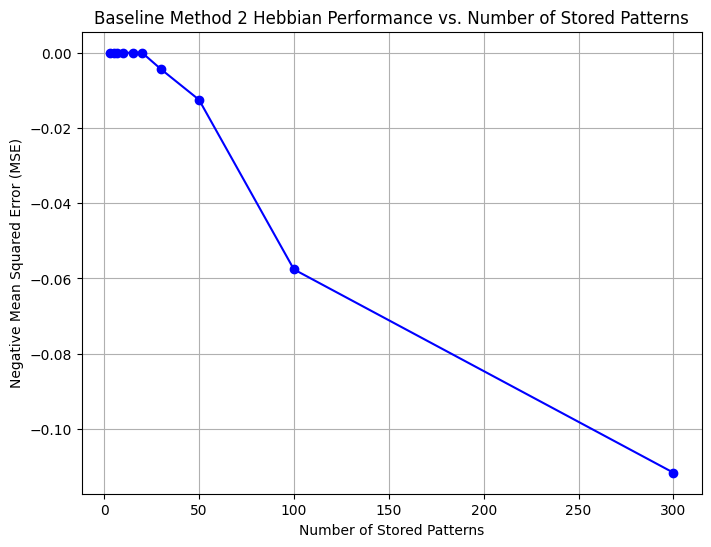

In [196]:

hebb_m2_results = []
hebb_m2_mse_values = []
num_patterns_list = [3, 5, 7, 10, 15, 20, 30, 50, 100, 300]

for i, num_patterns in enumerate(num_patterns_list):
    
    hopfield_gray = grayscaled_hp_baseline.HopfieldRNNGrayscale(num_units=8192)

    # randomly select from training set
    idxs = np.random.choice(range(len(stored_images)), size=num_patterns, replace=False)

    baseline_original = stored_images[idxs]
    baseline_masked = masked_images[idxs]

    hopfield_gray.store_patterns(baseline_original)

    retrieved_masked = hopfield_gray(baseline_masked).detach()
    
    # Convert back to grayscale
    retrieved_masked = torch.stack([grayscaled_hp_baseline.decode(img) for img in retrieved_masked])


    loss = hopfield_gray.recall_loss(baseline_masked, baseline_original)

    # Store the results for plotting later
    hebb_m2_results.append(retrieved_masked.detach().numpy())
    hebb_m2_mse_values.append(loss.detach().numpy())


# Plot the negative MSE curve (to make it appear decreasing)
plt.figure(figsize=(8, 6))
plt.plot(num_patterns_list, [-mse for mse in hebb_m2_mse_values], marker='o', linestyle='-', color='b')  # Negative SSE values
plt.title("Baseline Method 2 Hebbian Performance vs. Number of Stored Patterns")
plt.xlabel("Number of Stored Patterns")
plt.ylabel("Negative Mean Squared Error (MSE)")
plt.grid(True)
plt.show()



### Funny Tanh

Reconstruction MSE Loss (Masked Images): 0.0082
Reconstruction MSE Loss (Flipped Images): 0.0122


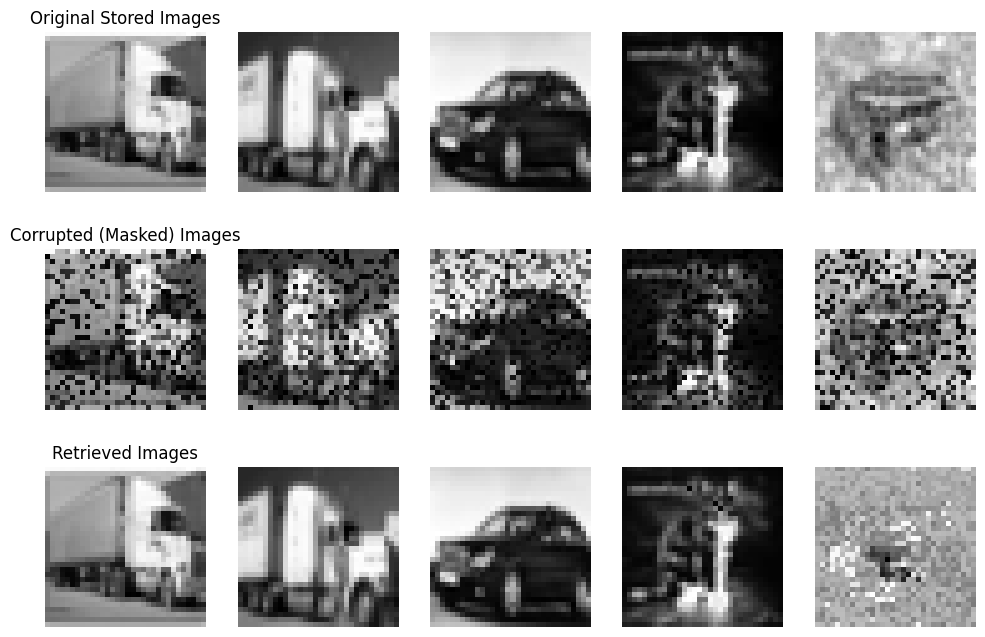

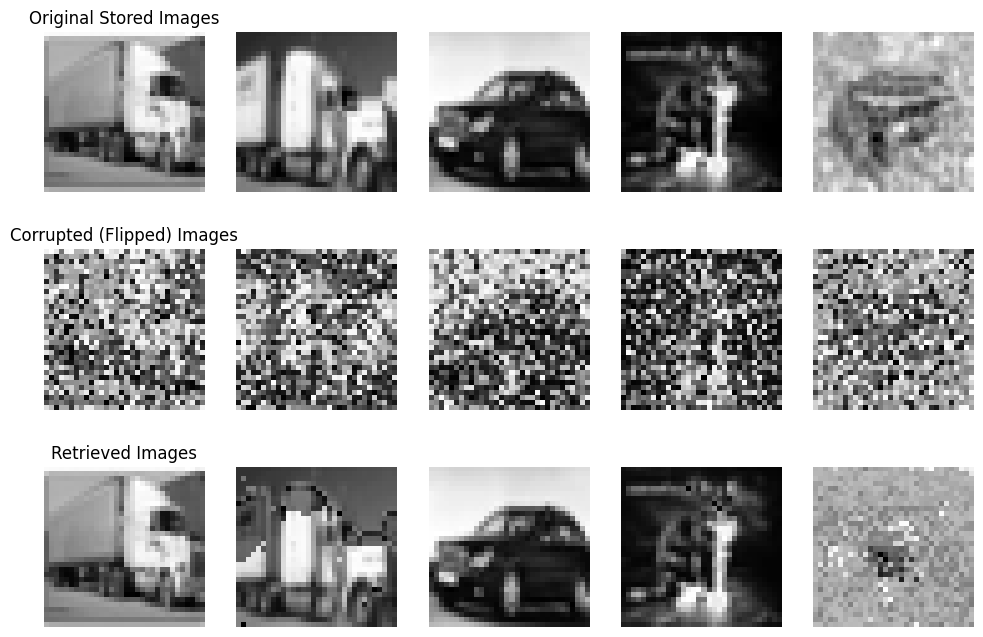

In [204]:
# Method 2 Preprocessing


# load training data
stored_images = np.load("data/grayscale_images/train_images.npy")
masked_images = np.load("data/grayscale_images/masked_images.npy")
flipped_images = np.load("data/grayscale_images/flipped_images.npy")

# convert to PyTorch tensors
stored_images = torch.tensor(stored_images, dtype=torch.float32)
masked_images = torch.tensor(masked_images, dtype=torch.float32)
flipped_images = torch.tensor(flipped_images, dtype=torch.float32)

importlib.reload(hopfield_baseline)
importlib.reload(grayscaled_hp_baseline)

num_neurons = 8192
num_patterns = 50
hopfield_gray = grayscaled_hp_baseline.HopfieldRNNGrayscaleTANH(num_units=num_neurons)

# randomly select from training set
idxs = np.random.choice(range(len(stored_images)), size=num_patterns, replace=False)

baseline_original = stored_images[idxs]
baseline_masked = masked_images[idxs]
baseline_flipped = flipped_images[idxs]

# store patterns using Hebbian learning
hopfield_gray.store_patterns(baseline_original)


# Retrieve images from corrupted inputs
retrieved_masked = hopfield_gray(baseline_masked).detach()
retrieved_flipped = hopfield_gray(baseline_flipped).detach()

# Convert back to grayscale
retrieved_masked = torch.stack([grayscaled_hp_baseline.decode(img) for img in retrieved_masked])
retrieved_flipped = torch.stack([grayscaled_hp_baseline.decode(img) for img in retrieved_flipped])

# Compute MSE Loss
loss_masked = hopfield_gray.recall_loss(baseline_masked, baseline_original)
loss_flipped = hopfield_gray.recall_loss(baseline_flipped, baseline_original)

print(f"Reconstruction MSE Loss (Masked Images): {loss_masked.item():.4f}")
print(f"Reconstruction MSE Loss (Flipped Images): {loss_flipped.item():.4f}")

baseline_original = torch.stack([grayscaled_hp_baseline.decode(img) for img in baseline_original])
baseline_masked = torch.stack([grayscaled_hp_baseline.decode(img) for img in baseline_masked])
baseline_flipped = torch.stack([grayscaled_hp_baseline.decode(img) for img in baseline_flipped])

# Plot results for masked images
plot_comparisons(baseline_original.numpy(), baseline_masked.numpy(), retrieved_masked,
                 "Corrupted (Masked) Images", "Retrieved Images")

# Plot results for flipped images
plot_comparisons(baseline_original.numpy(), baseline_flipped.numpy(), retrieved_flipped,
                 "Corrupted (Flipped) Images", "Retrieved Images")


#### Reconstructing Images for Increasing Stored Patterns

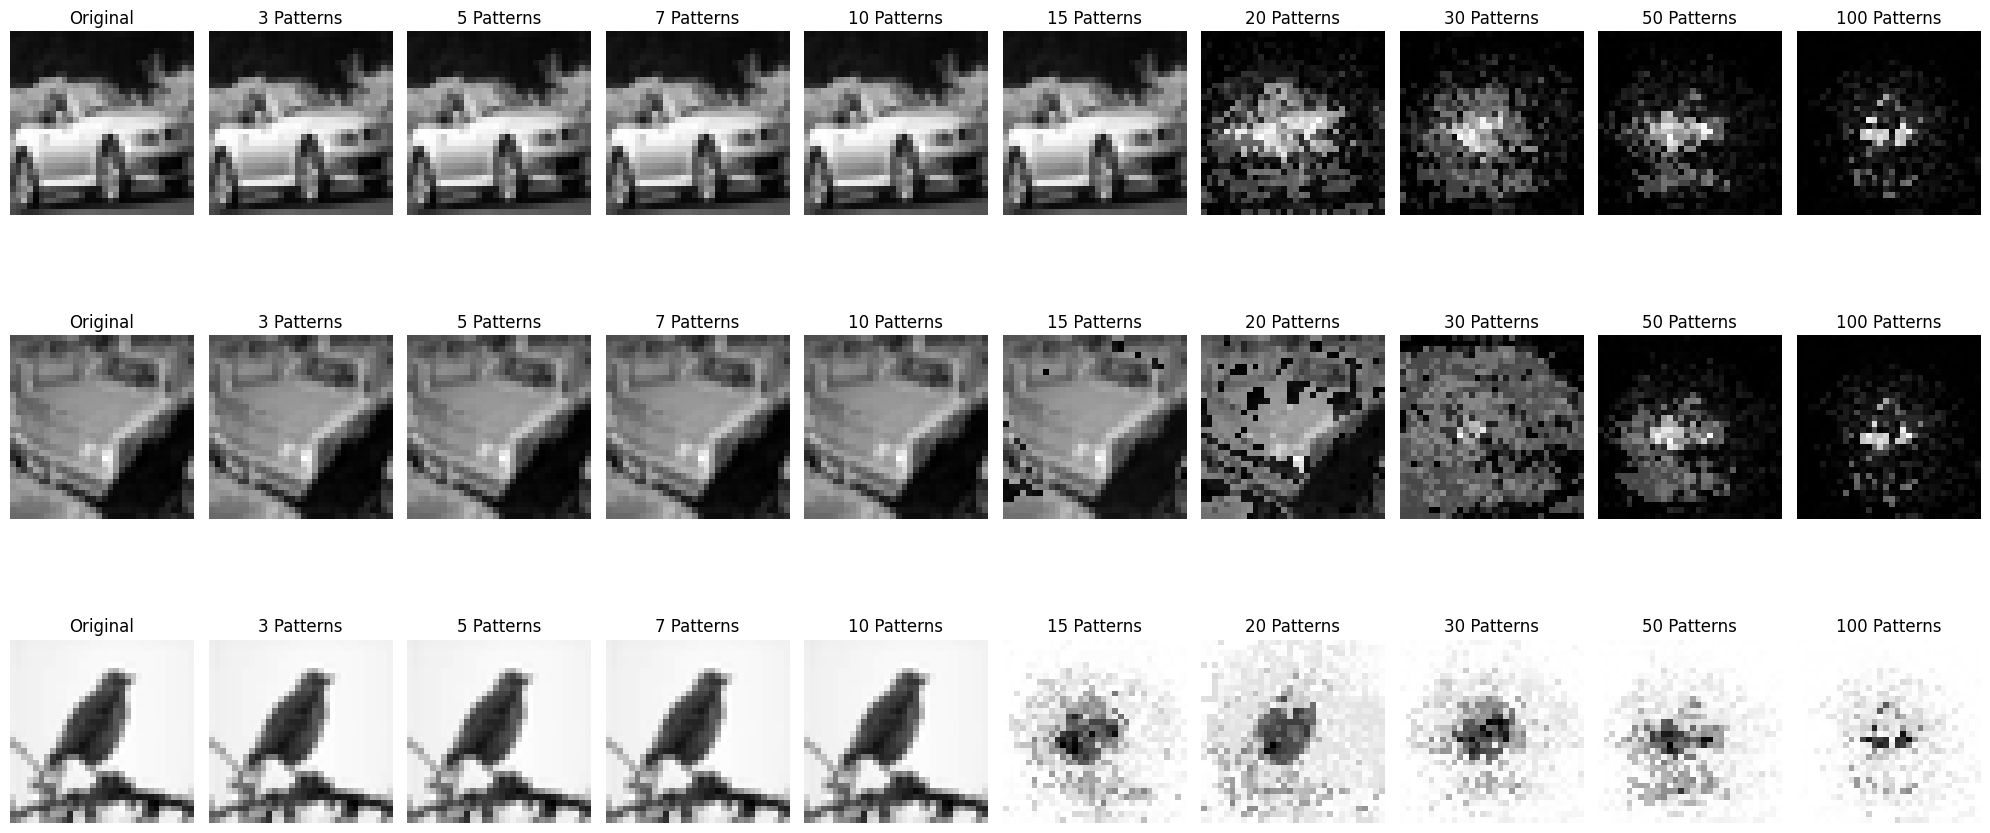

In [206]:
results = []
num_patterns_list = [3, 5, 7, 10, 15, 20, 30, 50, 100]
selected_idxs = set()
plot_idx = []

for i, num_patterns in enumerate(num_patterns_list):
    
    hopfield_gray = grayscaled_hp_baseline.HopfieldRNNGrayscaleTANH(num_units=8192)

    # Select new indices that have not been used previously
    remaining_idxs = list(set(range(len(stored_images))) - selected_idxs)  # The remaining available indices
    new_idxs = np.random.choice(remaining_idxs, size=num_patterns, replace=False)

    # Update the set of selected indices
    selected_idxs.update(new_idxs)

    if len(plot_idx) == 0:
        plot_idx = list(selected_idxs)

    baseline_original = stored_images[list(selected_idxs)]
    baseline_masked = masked_images[plot_idx]

    hopfield_gray.store_patterns(baseline_original)

    # Retrieve images from corrupted inputs
    retrieved_masked = hopfield_gray(baseline_masked).detach()

    # Convert back to grayscale
    retrieved_masked = torch.stack([grayscaled_hp_baseline.decode(img) for img in retrieved_masked])

    # Store the results for plotting later
    results.append(retrieved_masked)

# Create a large figure with an appropriate size
plt.figure(figsize=(20, 10))

# Loop through the rows (images)
for row, idx in enumerate(plot_idx, start=1):

    # Plot the original image
    plt.subplot(len(plot_idx), len(num_patterns_list)+1, (row-1)*(len(num_patterns_list)+1) + 1)
    plt.imshow(grayscaled_hp_baseline.decode(stored_images[plot_idx[row-1]]), cmap='gray')
    # plt.imshow(stored_images[plot_idx[row-1]].reshape(32,32), cmap='gray')
    plt.title(f'Original')
    plt.axis('off')

    # Plot the retrieved images for each number of patterns
    for i, num_patterns in enumerate(num_patterns_list):

        image_to_plot = results[i][row-1].reshape(32, 32)

        # Plot the image on the appropriate subplot axis
        plt.subplot(len(plot_idx), len(num_patterns_list)+1, (row-1)*(len(num_patterns_list)+1) + (i+2))
        plt.imshow(image_to_plot, cmap='gray')
        plt.title(f'{num_patterns} Patterns')
        plt.axis('off')

# Display the plots
plt.tight_layout()
plt.show()


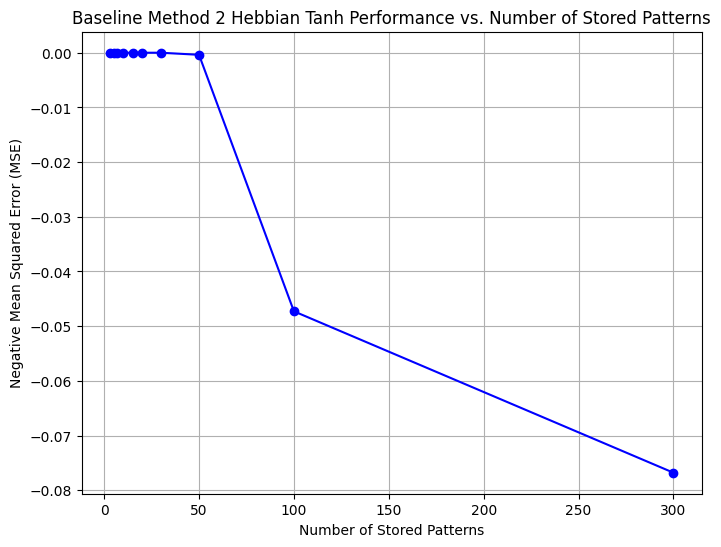

In [207]:

tanh_m2_results = []
tanh_m2_mse_values = []
num_patterns_list = [3, 5, 7, 10, 15, 20, 30, 50, 100, 300]

for i, num_patterns in enumerate(num_patterns_list):
    
    hopfield_gray = grayscaled_hp_baseline.HopfieldRNNGrayscaleTANH(num_units=8192)

    # randomly select from training set
    idxs = np.random.choice(range(len(stored_images)), size=num_patterns, replace=False)

    baseline_original = stored_images[idxs]
    baseline_masked = masked_images[idxs]

    hopfield_gray.store_patterns(baseline_original)

    retrieved_masked = hopfield_gray(baseline_masked).detach()
    
    # Convert back to grayscale
    retrieved_masked = torch.stack([grayscaled_hp_baseline.decode(img) for img in retrieved_masked])


    loss = hopfield_gray.recall_loss(baseline_masked, baseline_original)

    # Store the results for plotting later
    tanh_m2_results.append(retrieved_masked.detach().numpy())
    tanh_m2_mse_values.append(loss.detach().numpy())


# Plot the negative MSE curve (to make it appear decreasing)
plt.figure(figsize=(8, 6))
plt.plot(num_patterns_list, [-mse for mse in tanh_m2_mse_values], marker='o', linestyle='-', color='b')  # Negative SSE values
plt.title("Baseline Method 2 Hebbian Tanh Performance vs. Number of Stored Patterns")
plt.xlabel("Number of Stored Patterns")
plt.ylabel("Negative Mean Squared Error (MSE)")
plt.grid(True)
plt.show()



## Training Storkey Model

### Method 1

In [197]:
# load training data
stored_images = np.load("data/binarized/train_images.npy")
masked_images = np.load("data/binarized/masked_images.npy")
flipped_images = np.load("data/binarized/flipped_images.npy")

# convert to PyTorch tensors
stored_images = torch.tensor(stored_images, dtype=torch.float32)
masked_images = torch.tensor(masked_images, dtype=torch.float32)
flipped_images = torch.tensor(flipped_images, dtype=torch.float32)

In [198]:
importlib.reload(storkey)

num_neurons = 1024
num_patterns = 30
hopfield_storkey = storkey.HopfieldStorkey(num_units=num_neurons)

# randomly select from training set
idxs = np.random.choice(range(len(stored_images)), size=num_patterns, replace=False)

baseline_original = stored_images[idxs]
baseline_masked = masked_images[idxs]
baseline_flipped = flipped_images[idxs]

# store patterns using Hebbian learning
hopfield_storkey.store_patterns(baseline_original)

In [116]:
# Retrieve images from corrupted inputs
retrieved_masked = hopfield_storkey(baseline_masked)
retrieved_flipped = hopfield_storkey(baseline_flipped)

In [117]:
# Compute MSE Loss
loss_masked = hopfield_storkey.recall_loss(baseline_masked, baseline_original)
loss_flipped = hopfield_storkey.recall_loss(baseline_flipped, baseline_original)

print(f"Reconstruction MSE Loss (Masked Images): {loss_masked.item():.4f}")
print(f"Reconstruction MSE Loss (Flipped Images): {loss_flipped.item():.4f}")

print('-'*50)

# Compute accuracy
masked_acc = hopfield_storkey.recall_accuracy(baseline_masked, baseline_original)
flipped_acc = hopfield_storkey.recall_accuracy(baseline_flipped, baseline_original)

print(f"Reconstruction Accuracy (Masked Images): {masked_acc:.4f}")
print(f"Reconstruction Accuracy (Flipped Images): {flipped_acc:.4f}")

Reconstruction MSE Loss (Masked Images): 0.2543
Reconstruction MSE Loss (Flipped Images): 0.2576
--------------------------------------------------
Reconstruction Accuracy (Masked Images): 0.5000
Reconstruction Accuracy (Flipped Images): 0.5000


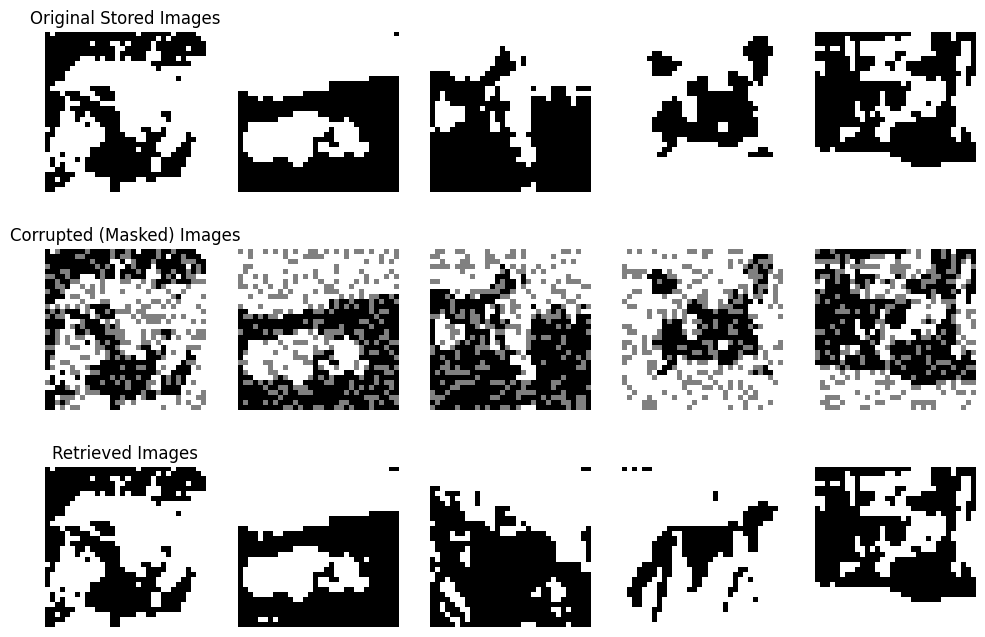

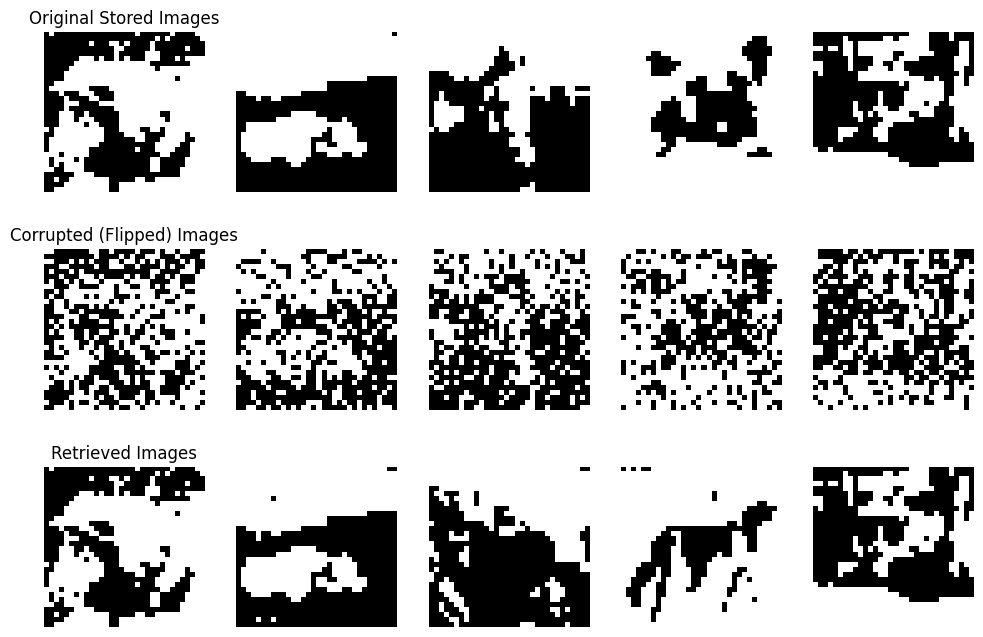

In [118]:
# Plot results for masked images
plot_comparisons(baseline_original.numpy(), baseline_masked.numpy(), retrieved_masked.detach().numpy(),
                 "Corrupted (Masked) Images", "Retrieved Images")

# Plot results for flipped images
plot_comparisons(baseline_original.numpy(), baseline_flipped.numpy(), retrieved_flipped.detach().numpy(),
                 "Corrupted (Flipped) Images", "Retrieved Images")

#### Reconstructing Images for Increasing Stored Patterns

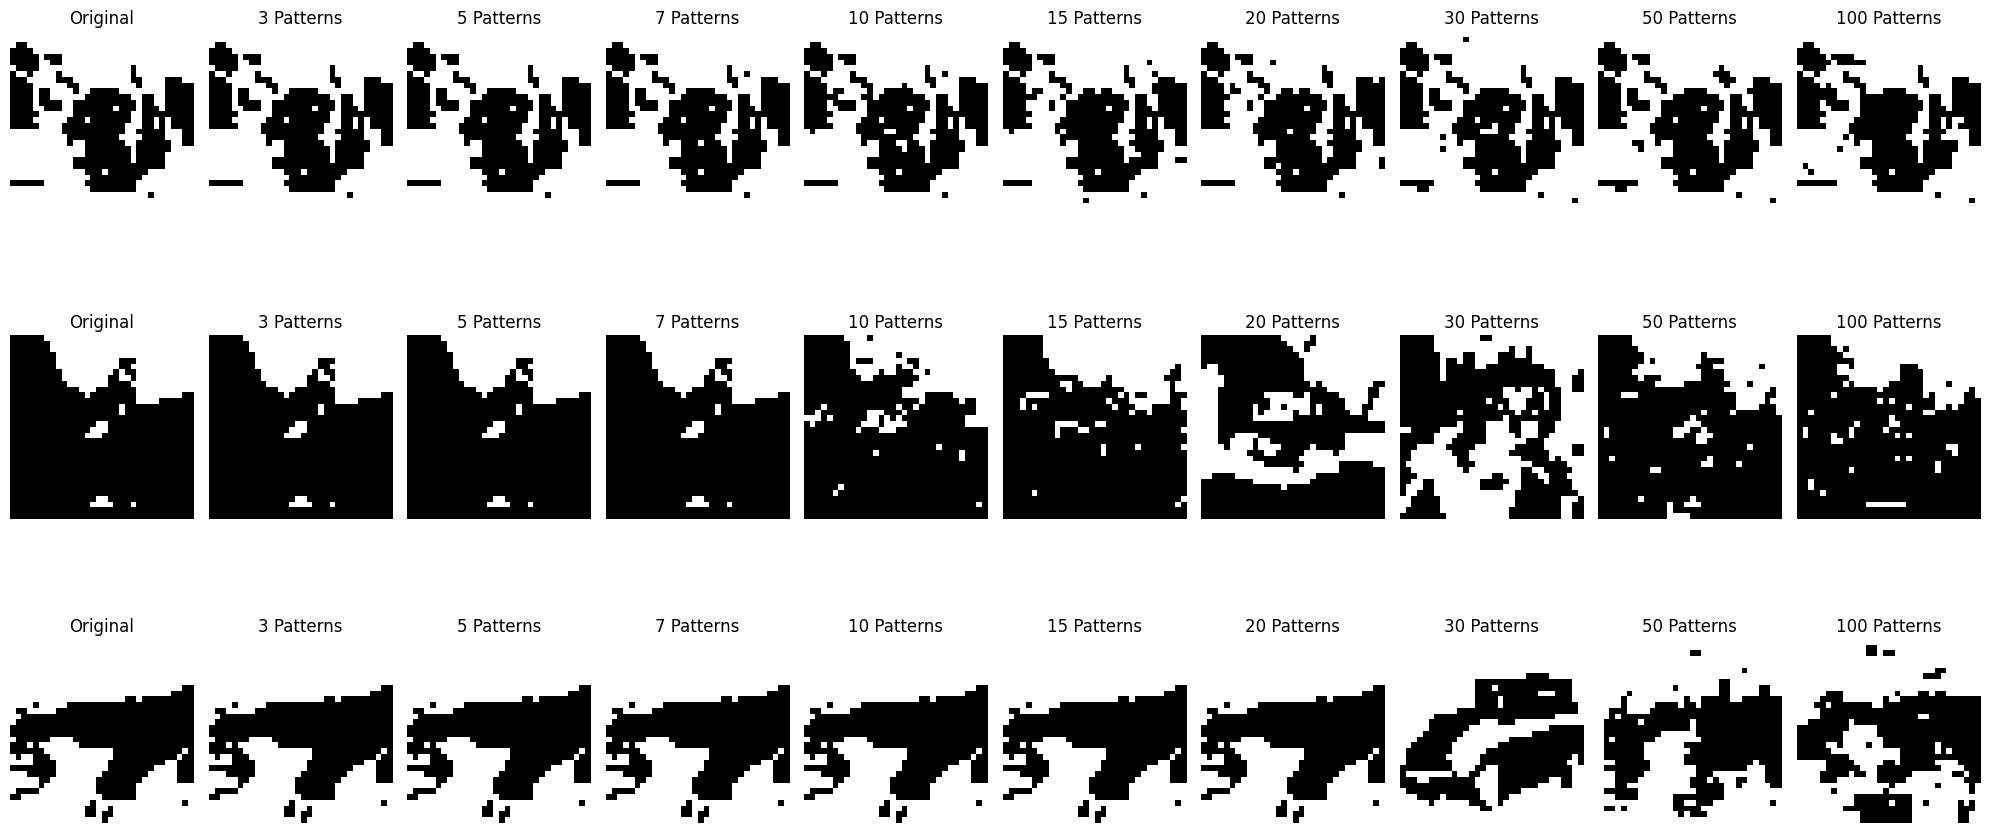

In [63]:
results = []
num_patterns_list = [3, 5, 7, 10, 15, 20, 30, 50, 100]
selected_idxs = set()
plot_idx = []

for i, num_patterns in enumerate(num_patterns_list):
    
    hopfield_storkey = storkey.HopfieldStorkey(num_units=1024)

    # Select new indices that have not been used previously
    remaining_idxs = list(set(range(len(stored_images))) - selected_idxs)  # The remaining available indices
    new_idxs = np.random.choice(remaining_idxs, size=num_patterns, replace=False)

    # Update the set of selected indices
    selected_idxs.update(new_idxs)

    if len(plot_idx) == 0:
        plot_idx = list(selected_idxs)

    baseline_original = stored_images[list(selected_idxs)]
    baseline_masked = masked_images[plot_idx]

    hopfield_storkey.store_patterns(baseline_original)

    retrieved_masked = hopfield_storkey(baseline_masked)

    # Store the results for plotting later
    results.append(retrieved_masked.detach().numpy())

# Create a large figure with an appropriate size
plt.figure(figsize=(20, 10))

# Loop through the rows (images)
for row, idx in enumerate(plot_idx, start=1):

    # Plot the original image
    plt.subplot(len(plot_idx), len(num_patterns_list)+1, (row-1)*(len(num_patterns_list)+1) + 1)
    plt.imshow(stored_images[plot_idx[row-1]].reshape(32,32), cmap='gray')
    plt.title(f'Original')
    plt.axis('off')

    # Plot the retrieved images for each number of patterns
    for i, num_patterns in enumerate(num_patterns_list):

        image_to_plot = results[i][row-1].reshape(32, 32)

        # Plot the image on the appropriate subplot axis
        plt.subplot(len(plot_idx), len(num_patterns_list)+1, (row-1)*(len(num_patterns_list)+1) + (i+2))
        plt.imshow(image_to_plot, cmap='gray')
        plt.title(f'{num_patterns} Patterns')
        plt.axis('off')

# Display the plots
plt.tight_layout()
plt.show()


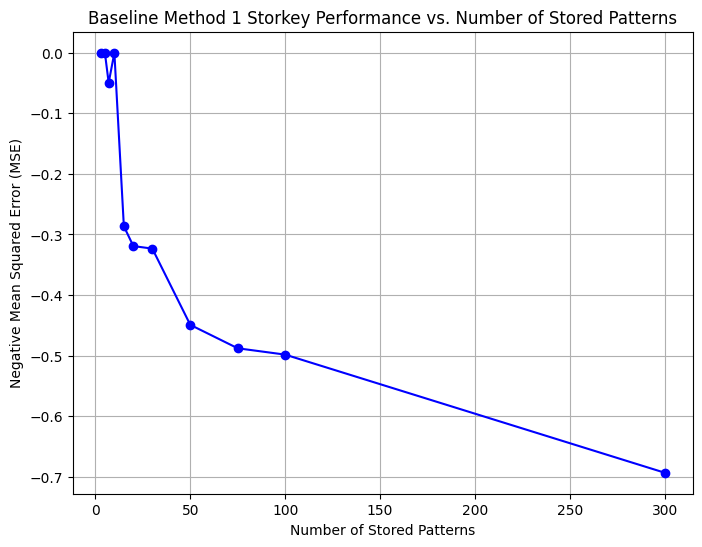

In [199]:

results = []
mse_values = []
num_patterns_list = [3, 5, 7, 10, 15, 20, 30, 50, 75, 100, 300]

for i, num_patterns in enumerate(num_patterns_list):
    
    hopfield_storkey = storkey.HopfieldStorkey(num_units=1024)

    # randomly select from training set
    idxs = np.random.choice(range(len(stored_images)), size=num_patterns, replace=False)

    baseline_original = stored_images[idxs]
    baseline_masked = masked_images[idxs]

    hopfield_storkey.store_patterns(baseline_original)

    retrieved_masked = hopfield_storkey(baseline_masked)
    loss = hopfield_storkey.recall_loss(baseline_masked, baseline_original)

    # Store the results for plotting later
    results.append(retrieved_masked.detach().numpy())
    mse_values.append(loss.detach().numpy())

# Plot the negative MSE curve (to make it appear decreasing)
plt.figure(figsize=(8, 6))
plt.plot(num_patterns_list, [-sse for sse in mse_values], marker='o', linestyle='-', color='b')  # Negative SSE values
plt.title("Baseline Method 1 Storkey Performance vs. Number of Stored Patterns")
plt.xlabel("Number of Stored Patterns")
plt.ylabel("Negative Mean Squared Error (MSE)")
plt.grid(True)
plt.show()



### Method 2

Reconstruction MSE Loss (Masked Images): 0.0000
Reconstruction MSE Loss (Flipped Images): 0.0000
--------------------------------------------------
Reconstruction Accuracy (Masked Images): 1.0000
Reconstruction Accuracy (Flipped Images): 1.0000


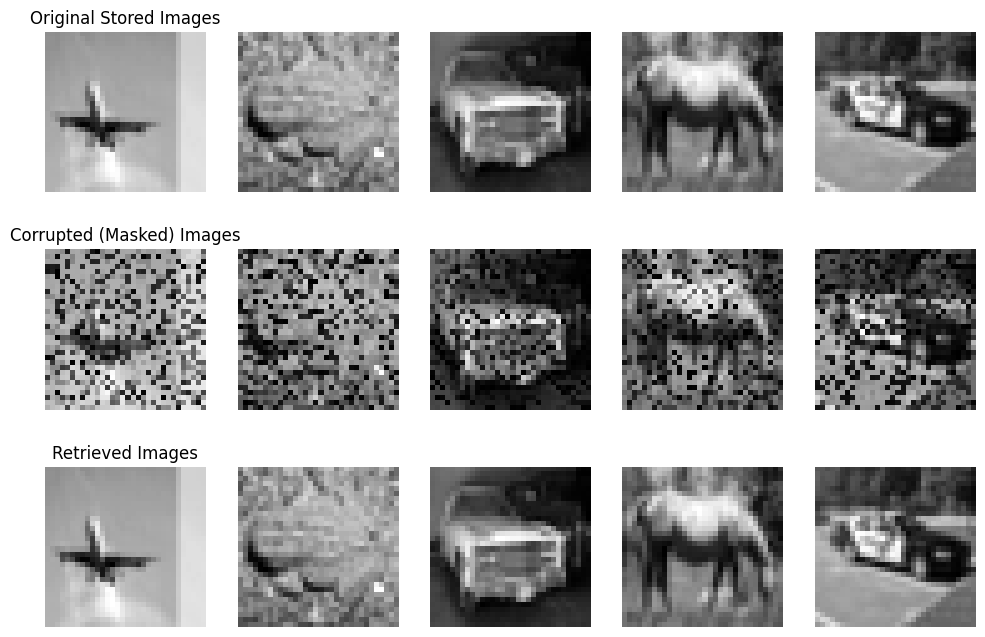

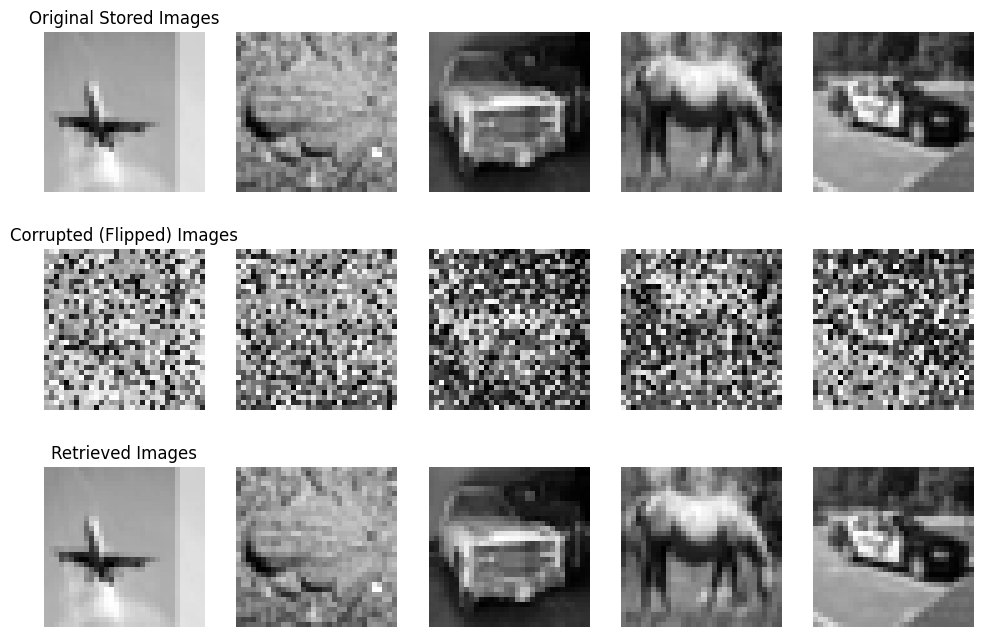

In [178]:
# Method 2 Preprocessing


# load training data
stored_images = np.load("data/grayscale_images/train_images.npy")
masked_images = np.load("data/grayscale_images/masked_images.npy")
flipped_images = np.load("data/grayscale_images/flipped_images.npy")

# convert to PyTorch tensors
stored_images = torch.tensor(stored_images, dtype=torch.float32)
masked_images = torch.tensor(masked_images, dtype=torch.float32)
flipped_images = torch.tensor(flipped_images, dtype=torch.float32)

importlib.reload(grayscaled_hp_baseline)
importlib.reload(storkey)

num_neurons = 8192
num_patterns = 45
hopfield_storkey = storkey.HopfieldStorkey(num_units=num_neurons)

# randomly select from training set
idxs = np.random.choice(range(len(stored_images)), size=num_patterns, replace=False)

baseline_original = stored_images[idxs]
baseline_masked = masked_images[idxs]
baseline_flipped = flipped_images[idxs]

# store patterns using Hebbian learning
hopfield_storkey.store_patterns(baseline_original)


# Retrieve images from corrupted inputs
retrieved_masked = hopfield_storkey(baseline_masked).detach()
retrieved_flipped = hopfield_storkey(baseline_flipped).detach()

# Convert back to grayscale
retrieved_masked = torch.stack([grayscaled_hp_baseline.decode(img) for img in retrieved_masked])
retrieved_flipped = torch.stack([grayscaled_hp_baseline.decode(img) for img in retrieved_flipped])

# Compute MSE Loss
loss_masked = hopfield_storkey.recall_loss(baseline_masked, baseline_original)
loss_flipped = hopfield_storkey.recall_loss(baseline_flipped, baseline_original)

print(f"Reconstruction MSE Loss (Masked Images): {loss_masked.item():.4f}")
print(f"Reconstruction MSE Loss (Flipped Images): {loss_flipped.item():.4f}")

print('-'*50)

# Compute accuracy
masked_acc = hopfield_storkey.recall_accuracy(baseline_masked, baseline_original)
flipped_acc = hopfield_storkey.recall_accuracy(baseline_flipped, baseline_original)

print(f"Reconstruction Accuracy (Masked Images): {masked_acc:.4f}")
print(f"Reconstruction Accuracy (Flipped Images): {flipped_acc:.4f}")

baseline_original = torch.stack([grayscaled_hp_baseline.decode(img) for img in baseline_original])
baseline_masked = torch.stack([grayscaled_hp_baseline.decode(img) for img in baseline_masked])
baseline_flipped = torch.stack([grayscaled_hp_baseline.decode(img) for img in baseline_flipped])

# Plot results for masked images
plot_comparisons(baseline_original.numpy(), baseline_masked.numpy(), retrieved_masked,
                 "Corrupted (Masked) Images", "Retrieved Images")

# Plot results for flipped images
plot_comparisons(baseline_original.numpy(), baseline_flipped.numpy(), retrieved_flipped,
                 "Corrupted (Flipped) Images", "Retrieved Images")


#### Reconstructing Images for Increasing Stored Patterns

In [182]:
results = []
num_patterns_list = [3, 5, 7, 10, 15, 20, 30, 50, 100, 300]
selected_idxs = set()
plot_idx = []

for i, num_patterns in enumerate(num_patterns_list):
    
    hopfield_storkey = storkey.HopfieldStorkey(num_units=8192)

    # Select new indices that have not been used previously
    remaining_idxs = list(set(range(len(stored_images))) - selected_idxs)  # The remaining available indices
    new_idxs = np.random.choice(remaining_idxs, size=num_patterns, replace=False)

    # Update the set of selected indices
    selected_idxs.update(new_idxs)

    if len(plot_idx) == 0:
        plot_idx = list(selected_idxs)

    baseline_original = stored_images[list(selected_idxs)]
    baseline_masked = masked_images[plot_idx]

    hopfield_storkey.store_patterns(baseline_original)

    # Retrieve images from corrupted inputs
    retrieved_masked = hopfield_storkey(baseline_masked).detach()

    # Convert back to grayscale
    retrieved_masked = torch.stack([grayscaled_hp_baseline.decode(img) for img in retrieved_masked])

    # Store the results for plotting later
    results.append(retrieved_masked)

# Create a large figure with an appropriate size
plt.figure(figsize=(20, 10))

# Loop through the rows (images)
for row, idx in enumerate(plot_idx, start=1):

    # Plot the original image
    plt.subplot(len(plot_idx), len(num_patterns_list)+1, (row-1)*(len(num_patterns_list)+1) + 1)
    plt.imshow(grayscaled_hp_baseline.decode(stored_images[plot_idx[row-1]]), cmap='gray')
    # plt.imshow(stored_images[plot_idx[row-1]].reshape(32,32), cmap='gray')
    plt.title(f'Original')
    plt.axis('off')

    # Plot the retrieved images for each number of patterns
    for i, num_patterns in enumerate(num_patterns_list):

        image_to_plot = results[i][row-1].reshape(32, 32)

        # Plot the image on the appropriate subplot axis
        plt.subplot(len(plot_idx), len(num_patterns_list)+1, (row-1)*(len(num_patterns_list)+1) + (i+2))
        plt.imshow(image_to_plot, cmap='gray')
        plt.title(f'{num_patterns} Patterns')
        plt.axis('off')

# Display the plots
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

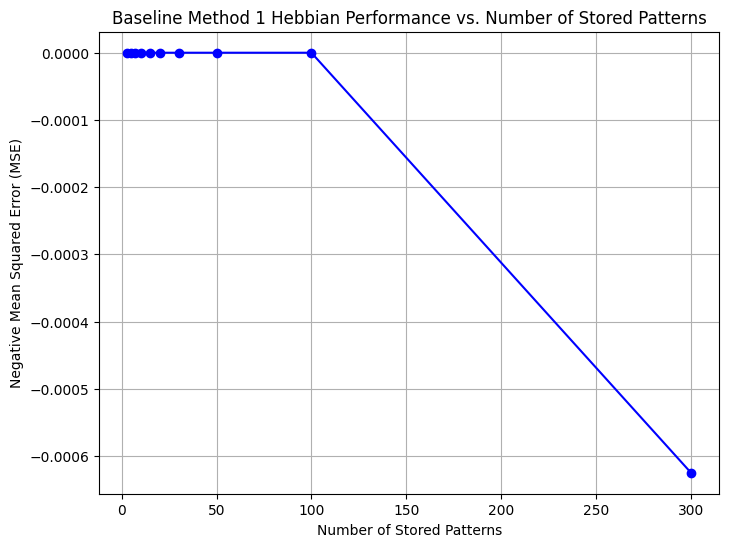

In [181]:

stor_m2_results = []
stor_m2_mse_values = []
num_patterns_list = [3, 5, 7, 10, 15, 20, 30, 50, 100, 300]

for i, num_patterns in enumerate(num_patterns_list):
    
    hopfield_storkey = storkey.HopfieldStorkey(num_units=8192)

    # randomly select from training set
    idxs = np.random.choice(range(len(stored_images)), size=num_patterns, replace=False)

    baseline_original = stored_images[idxs]
    baseline_masked = masked_images[idxs]

    hopfield_storkey.store_patterns(baseline_original)

    retrieved_masked = hopfield_storkey(baseline_masked).detach()
    
    # Convert back to grayscale
    retrieved_masked = torch.stack([grayscaled_hp_baseline.decode(img) for img in retrieved_masked])

    loss = hopfield_storkey.recall_loss(baseline_masked, baseline_original)

    # Store the results for plotting later
    stor_m2_results.append(retrieved_masked.detach().numpy())
    stor_m2_mse_values.append(loss.detach().numpy())


# Plot the negative MSE curve (to make it appear decreasing)
plt.figure(figsize=(8, 6))
plt.plot(num_patterns_list, [-mse for mse in stor_m2_mse_values], marker='o', linestyle='-', color='b')  # Negative SSE values
plt.title("Baseline Method 2 Storkey Performance vs. Number of Stored Patterns")
plt.xlabel("Number of Stored Patterns")
plt.ylabel("Negative Mean Squared Error (MSE)")
plt.grid(True)
plt.show()



## Training Phase Space Learning

In [125]:
# load training data
stored_images = np.load("data/binarized/train_images.npy")
masked_images = np.load("data/binarized/masked_images.npy")
flipped_images = np.load("data/binarized/flipped_images.npy")

# convert to PyTorch tensors
stored_images = torch.tensor(stored_images, dtype=torch.float32)
masked_images = torch.tensor(masked_images, dtype=torch.float32)
flipped_images = torch.tensor(flipped_images, dtype=torch.float32)

In [126]:
importlib.reload(hopfield_PSL)
num_neurons = 1024
num_patterns = 15
epochs = 10
lr = 0.001
model = hopfield_PSL.HopfieldPSL()

optimizer = optim.Adam(params=model.parameters(), lr=lr)
criterion = nn.MSELoss()

idxs = np.random.choice(range(len(stored_images)), size=num_patterns, replace=False)
original = [stored_images[i] for i in idxs]
corrupted = [masked_images[i] for i in idxs]
targets = [tensor * 0.9 for tensor in original]

In [127]:
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for i in range(len(original)):
        optimizer.zero_grad()          # Clear gradients
        output = model(original[i])          # Forward pass
        loss = criterion(output, targets[i])  # Compute reconstruction loss
        loss.backward()                  # Backpropagation
        optimizer.step()                 # Update weights
        
        total_loss += loss.item()
    avg_loss = total_loss / len(original)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")

Epoch [1/10], Loss: 1.114564
Epoch [2/10], Loss: 0.733393
Epoch [3/10], Loss: 0.148969
Epoch [4/10], Loss: 0.086828
Epoch [5/10], Loss: 0.071947
Epoch [6/10], Loss: 0.074723
Epoch [7/10], Loss: 0.084223
Epoch [8/10], Loss: 0.091198
Epoch [9/10], Loss: 0.103608
Epoch [10/10], Loss: 0.121816


In [128]:
retrieved = [torch.sign(model(model(model(model(img))))).detach().numpy() for img in corrupted]

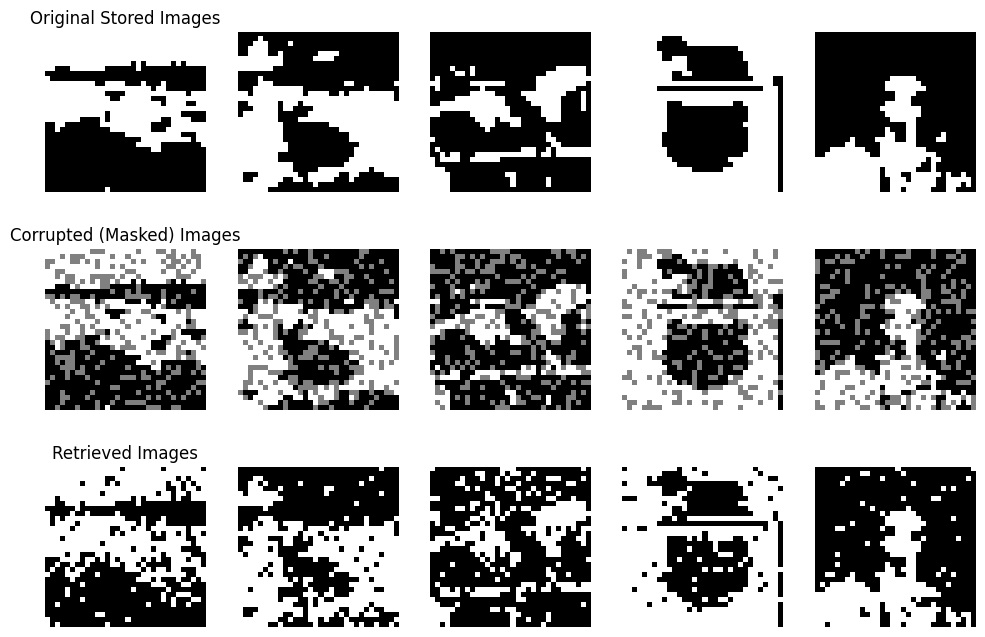

In [129]:
plot_comparisons(original, corrupted, retrieved, "Corrupted (Masked) Images", "Retrieved Images")

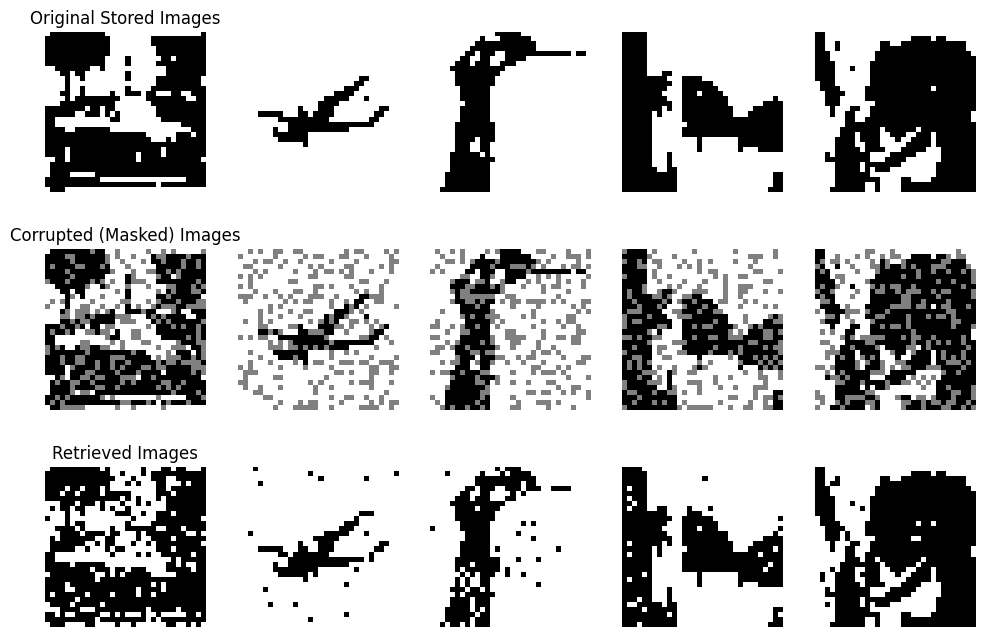

In [122]:
# Plot results for masked images
plot_comparisons(original, corrupted, retrieved, "Corrupted (Masked) Images", "Retrieved Images")

## Training Spiking

In [ ]:
# load training data
stored_images = np.load("data/binarized/train_images.npy")
masked_images = np.load("data/binarized/masked_images.npy")
flipped_images = np.load("data/binarized/flipped_images.npy")

In [ ]:
importlib.reload(spiking)

spyking_model = spiking.SpikingHN(N=1024)

num_patterns = 15

# randomly select from training set
idxs = np.random.choice(range(len(stored_images)), size=num_patterns, replace=False)
spyking_patterns = stored_images[idxs]
spyking_masked = masked_images[idxs]
spyking_flipped = flipped_images[idxs]

spyking_model.train(spyking_patterns)


In [146]:
firings, voltages = spyking_model.forward(spyking_masked[0])

### Recalling Increasing Number of Patterns